# Import the libraries 

In [1]:
from tensorflow import keras
import tensorflow as tf
from keras.models import Model
from keras import Input
from keras.layers import Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.utils import plot_model
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import graphviz
import sys
import os
import cv2
main_dir=os.path.dirname(sys.path[0])

# Data load

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2023-07-02 16:37:25.814015: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-02 16:37:25.822166: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-02 16:37:25.822345: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
train_imgs = sorted(os.listdir('/home/pl/Documents/practice_data/train'))
train_cleaned_imgs = sorted(os.listdir('/home/pl/Documents/practice_data/train_cleaned'))
test_imgs = sorted(os.listdir('/home/pl/Documents/practice_data/test'))

# Data preprocessing

In [4]:
train_img = cv2.imread('/home/pl/Documents/practice_data/train/101.png')
train_img_arr = np.asarray(train_img, dtype="float32")
train_resize_img = cv2.resize(train_img_arr, (270, 210))
normalize_train_imd = train_resize_img/255.0
train_reshape_img = np.reshape(normalize_train_imd, (210, 270,3))

In [5]:
train_cleaned_img = cv2.imread('/home/pl/Documents/practice_data/train_cleaned/101.png')
train_cleaned_img_arr = np.asarray(train_cleaned_img, dtype="float32")
train_cleaned_resize_img = cv2.resize(train_cleaned_img_arr, (270, 210))
normalize_train_cleaned_img = train_cleaned_resize_img/255.0
train_cleaned_reshape_img = np.reshape(normalize_train_cleaned_img, (210, 270,3))

In [6]:
test_img = cv2.imread('/home/pl/Documents/practice_data/test/1.png')
test_img_arr = np.asarray(test_img, dtype="float32")
test_resize_img = cv2.resize(test_img_arr, (270, 210))
normalize_test_imd = test_resize_img/255.0
test_reshape_img = np.reshape(normalize_test_imd, (210, 270,3))

In [7]:
train = []
train_cleaned = []
test = []

for i in train_imgs:
    train.append(train_reshape_img)
    
for i in train_cleaned_imgs:
    train_cleaned.append(train_cleaned_reshape_img)
    
for i in test_imgs:
    test.append(test_reshape_img)

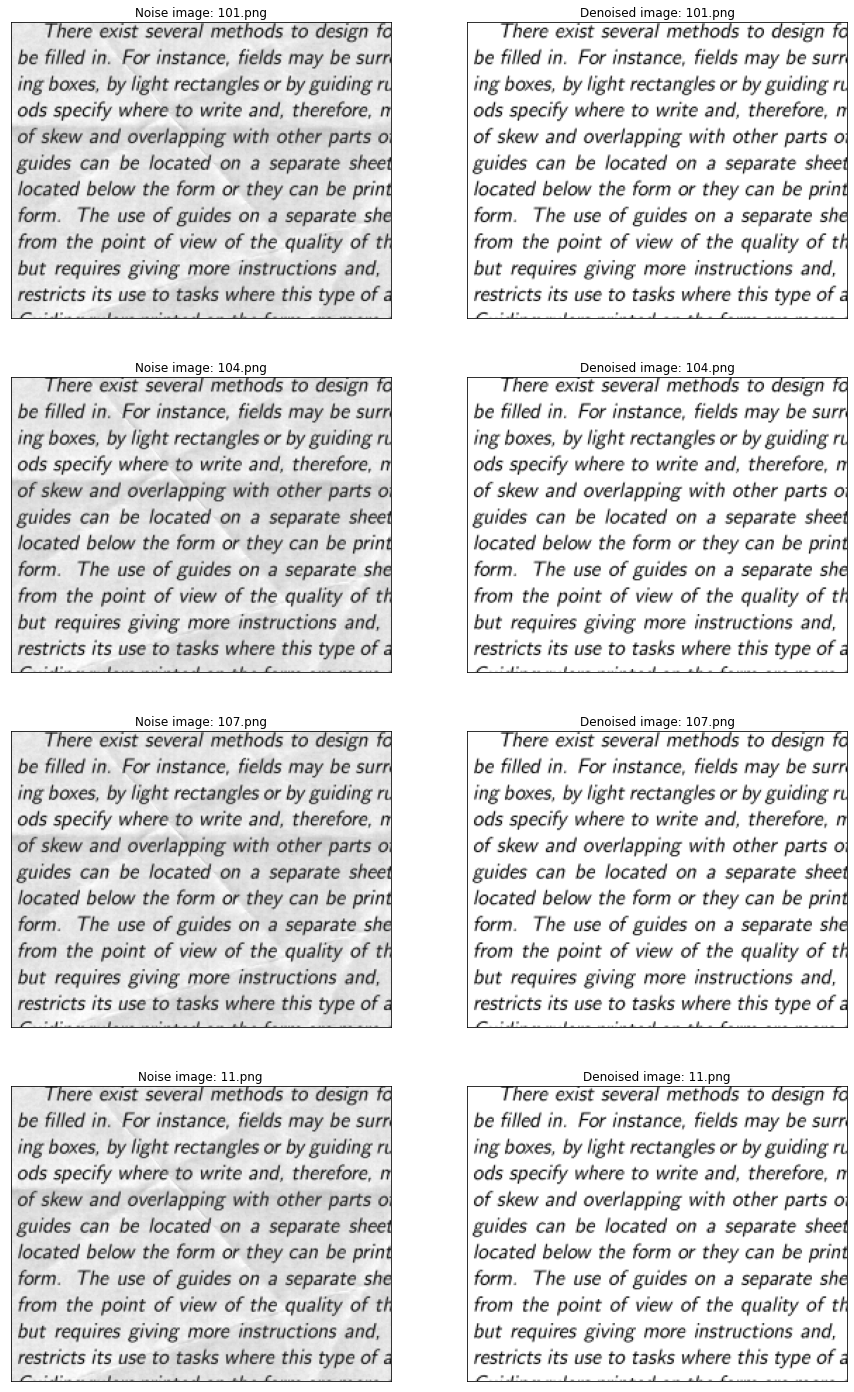

In [8]:
plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train[i][:,:,0], cmap='gray')
    plt.title('Noise image: {}'.format(train_imgs[i]))
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_cleaned[i][:,:,0], cmap='gray')
    plt.title('Denoised image: {}'.format(train_imgs[i]))

plt.show()

# Split data

In [9]:
from sklearn.model_selection import train_test_split

X_train = np.asarray(train)
Y_train = np.asarray(train_cleaned[1:])
X_test = np.asarray(test)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.15)

In [10]:
#--- Input Layer 
visible = Input(shape=(210, 270, 3), name='Input-Layer') # Specify input shape

#--- Encoder Layer
e = Dense(units=210, name='Encoder-Layer')(visible)
e = BatchNormalization(name='Encoder-Layer-Normalization')(e)
e = LeakyReLU(name='Encoder-Layer-Activation')(e)

#--- Middle Layer
middle = Dense(units=210, activation='linear', activity_regularizer=keras.regularizers.L1(0.0001), name='Middle-Hidden-Layer')(e)

#--- Decoder Layer
d = Dense(units=210, name='Decoder-Layer')(middle)
d = BatchNormalization(name='Decoder-Layer-Normalization')(d)
d = LeakyReLU(name='Decoder-Layer-Activation')(d)

#--- Output layer
output = Dense(units=3, activation='sigmoid', name='Output-Layer')(d)

# Define denoising autoencoder model
model = Model(inputs=visible, outputs=output, name='Denoising-Autoencoder-Model')

# Compile denoising autoencoder model
model.compile(optimizer='adam', loss='mse')

# Print model summary
print(model.summary())

Model: "Denoising-Autoencoder-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input-Layer (InputLayer)    [(None, 210, 270, 3)]     0         
                                                                 
 Encoder-Layer (Dense)       (None, 210, 270, 210)     840       
                                                                 
 Encoder-Layer-Normalization  (None, 210, 270, 210)    840       
  (BatchNormalization)                                           
                                                                 
 Encoder-Layer-Activation (L  (None, 210, 270, 210)    0         
 eakyReLU)                                                       
                                                                 
 Middle-Hidden-Layer (Dense)  (None, 210, 270, 210)    44310     
                                                                 
 Decoder-Layer (Dense)       (None, 210

2023-07-02 16:39:34.163949: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-02 16:39:34.164365: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-02 16:39:34.164581: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-02 16:39:34.164730: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Epoch 1/20


2023-07-02 15:49:34.063111: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


61/61 [==============================] - 12s 153ms/step - loss: 38.6299 - val_loss: 13.5676
Epoch 2/20
61/61 [==============================] - 9s 150ms/step - loss: 5.8940 - val_loss: 12.5684
Epoch 3/20
61/61 [==============================] - 9s 150ms/step - loss: 5.9370 - val_loss: 15.8061
Epoch 4/20
61/61 [==============================] - 9s 150ms/step - loss: 5.7483 - val_loss: 19.7820
Epoch 5/20
61/61 [==============================] - 9s 149ms/step - loss: 5.5020 - val_loss: 24.3627
Epoch 6/20
61/61 [==============================] - 9s 150ms/step - loss: 5.1222 - val_loss: 32.1242
Epoch 7/20
61/61 [==============================] - 9s 149ms/step - loss: 5.0079 - val_loss: 38.8286
Epoch 8/20
61/61 [==============================] - 9s 142ms/step - loss: 4.8878 - val_loss: 47.5451
Epoch 9/20
61/61 [==============================] - 9s 149ms/step - loss: 4.8564 - val_loss: 60.5301
Epoch 10/20
61/61 [==============================] - 9s 149ms/step - loss: 4.6353 - val_loss: 73.440

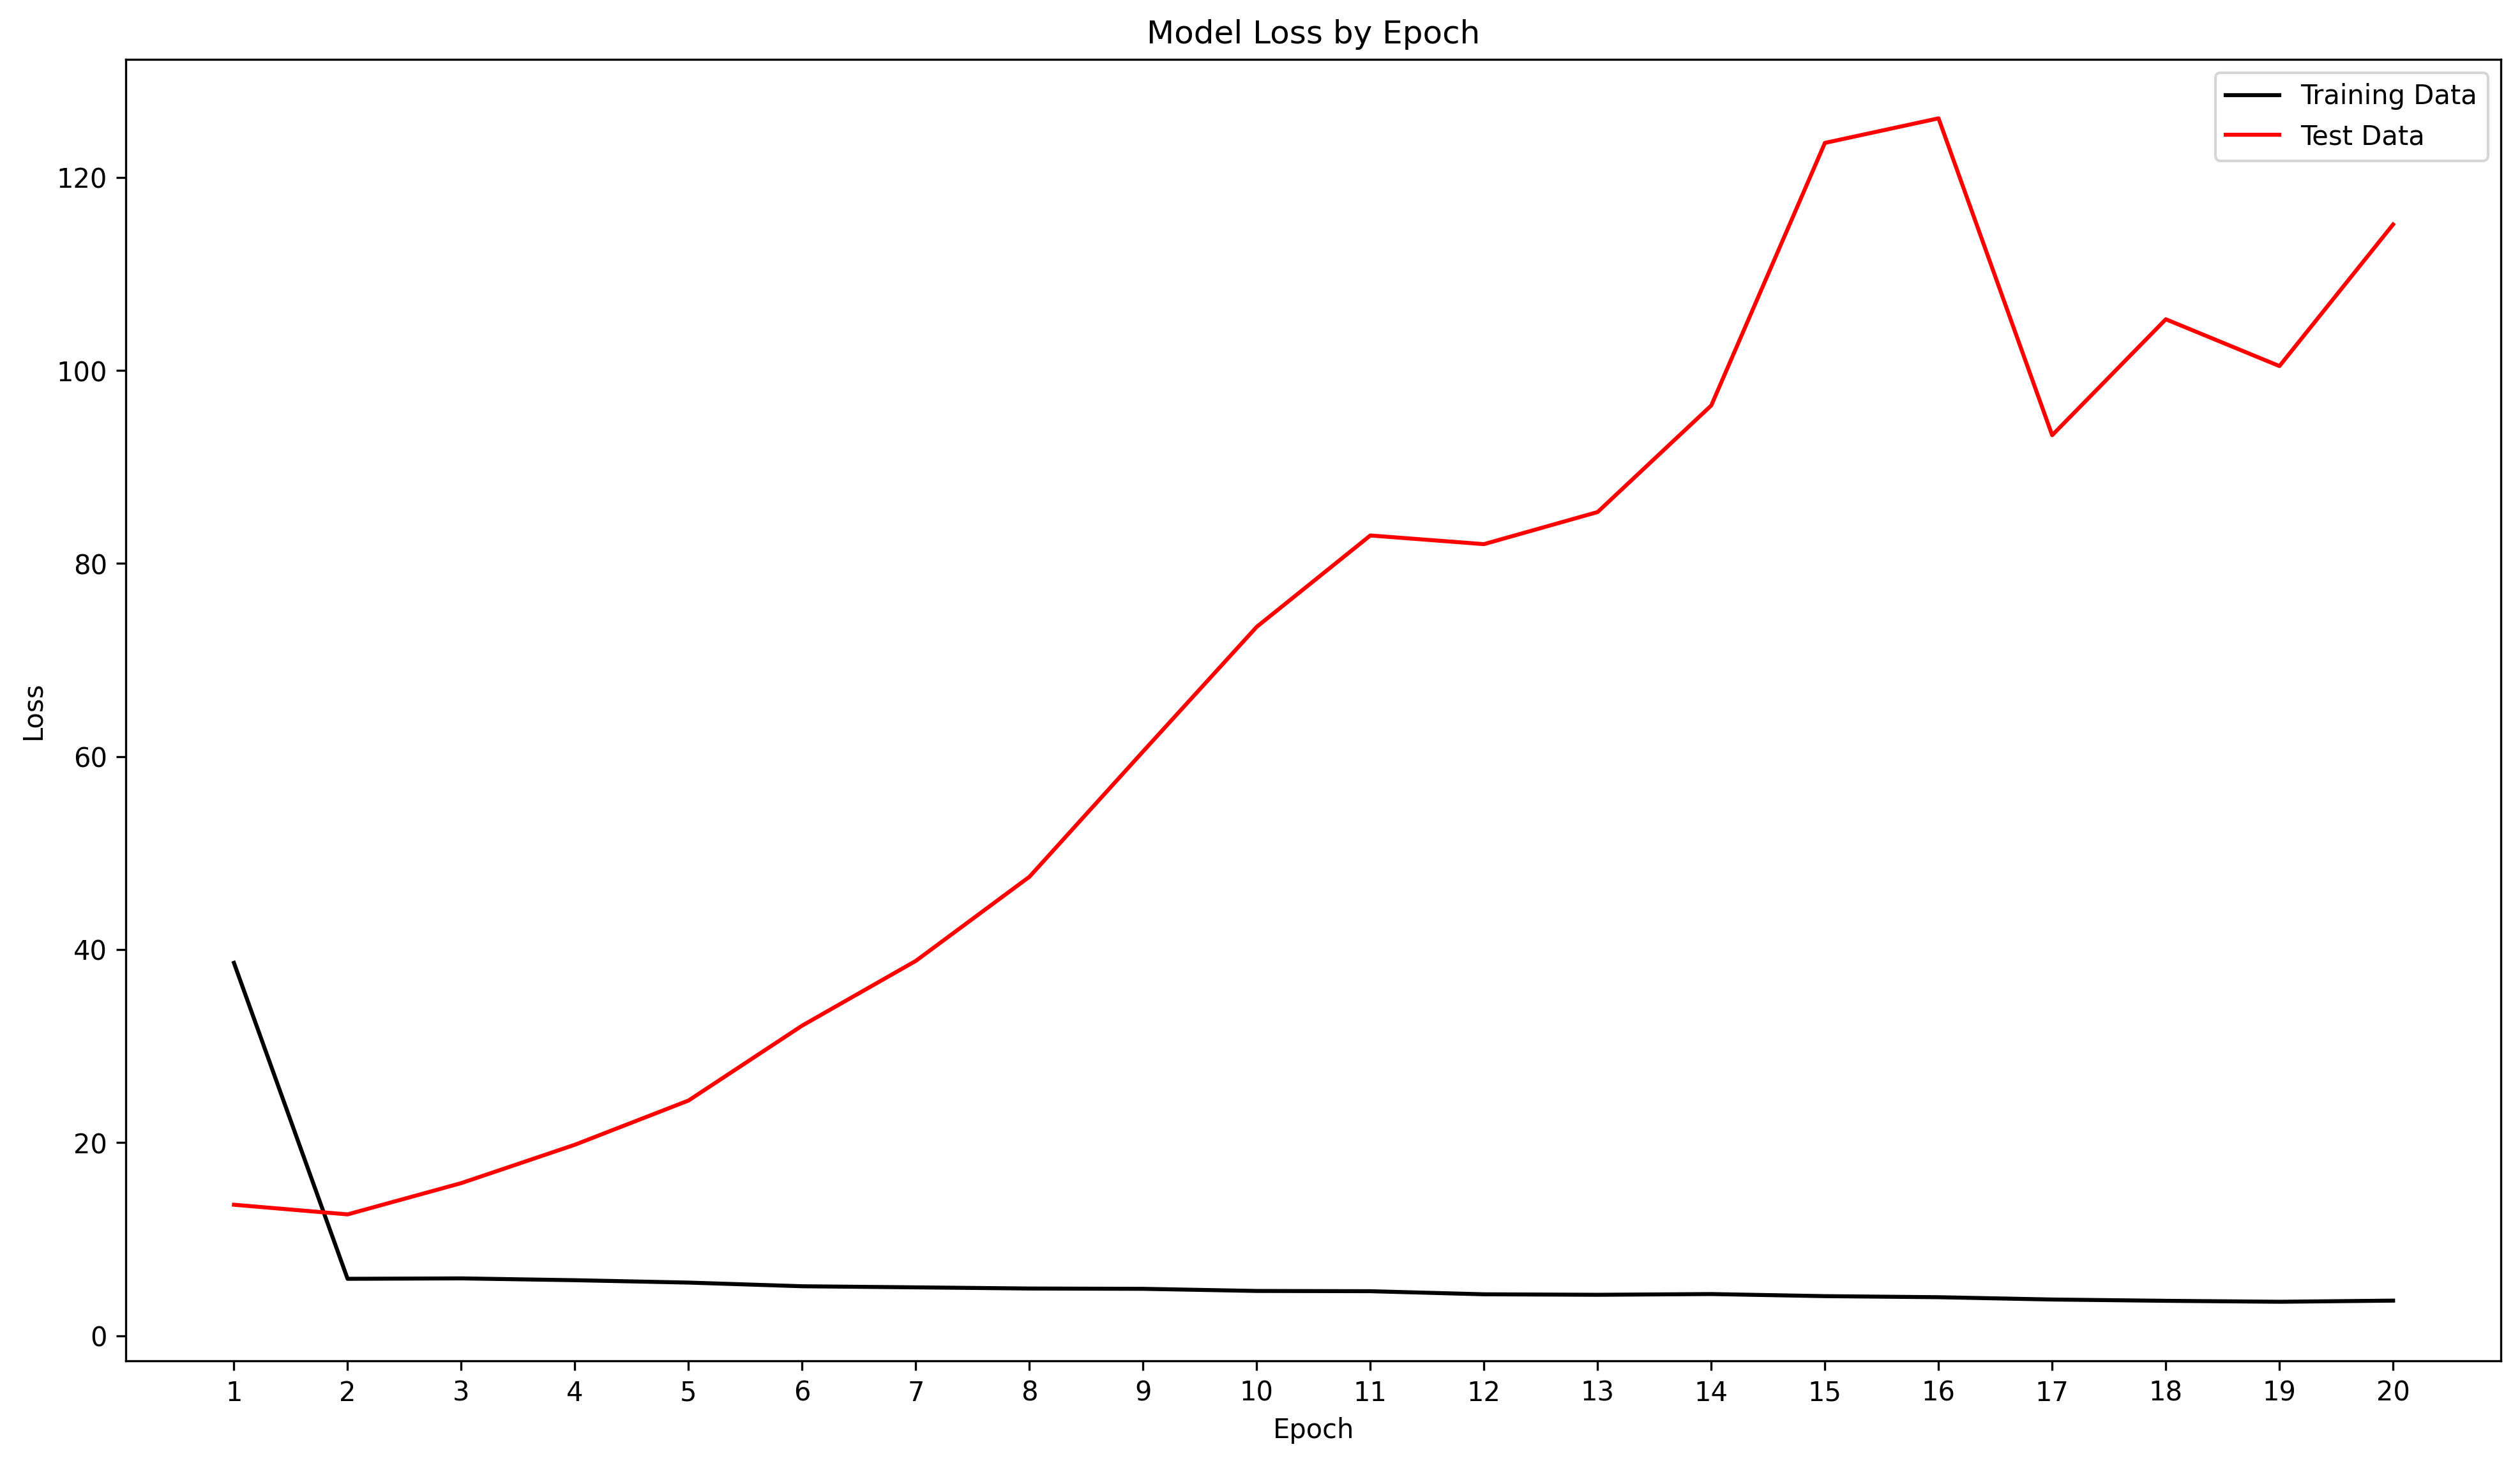

In [11]:
history = model.fit(X_train, Y_train, epochs=20, batch_size=2, verbose=1, validation_data=(X_val, Y_val))

# Plot a loss chart
fig, ax = plt.subplots(figsize=(16,9), dpi=300)
plt.title(label='Model Loss by Epoch', loc='center')

ax.plot(history.history['loss'], label='Training Data', color='black')
ax.plot(history.history['val_loss'], label='Test Data', color='red')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.xticks(ticks=np.arange(len(history.history['loss'])), labels=np.arange(1, len(history.history['loss'])+1))
plt.legend()

plt.show()

Epoch 1/20


2023-07-02 16:21:15.104438: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


31/31 [==============================] - 10s 302ms/step - loss: 79.8714 - val_loss: 17.0808
Epoch 2/20
31/31 [==============================] - 9s 295ms/step - loss: 8.9895 - val_loss: 12.9161
Epoch 3/20
31/31 [==============================] - 9s 295ms/step - loss: 5.3985 - val_loss: 11.6925
Epoch 4/20
31/31 [==============================] - 9s 296ms/step - loss: 5.5621 - val_loss: 12.6304
Epoch 5/20
31/31 [==============================] - 9s 295ms/step - loss: 5.5817 - val_loss: 13.7238
Epoch 6/20
31/31 [==============================] - 9s 296ms/step - loss: 5.4728 - val_loss: 15.4311
Epoch 7/20
31/31 [==============================] - 9s 296ms/step - loss: 5.6726 - val_loss: 16.9884
Epoch 8/20
31/31 [==============================] - 9s 295ms/step - loss: 5.6171 - val_loss: 18.7397
Epoch 9/20
31/31 [==============================] - 9s 295ms/step - loss: 5.3281 - val_loss: 20.3262
Epoch 10/20
31/31 [==============================] - 9s 295ms/step - loss: 4.9735 - val_loss: 22.633

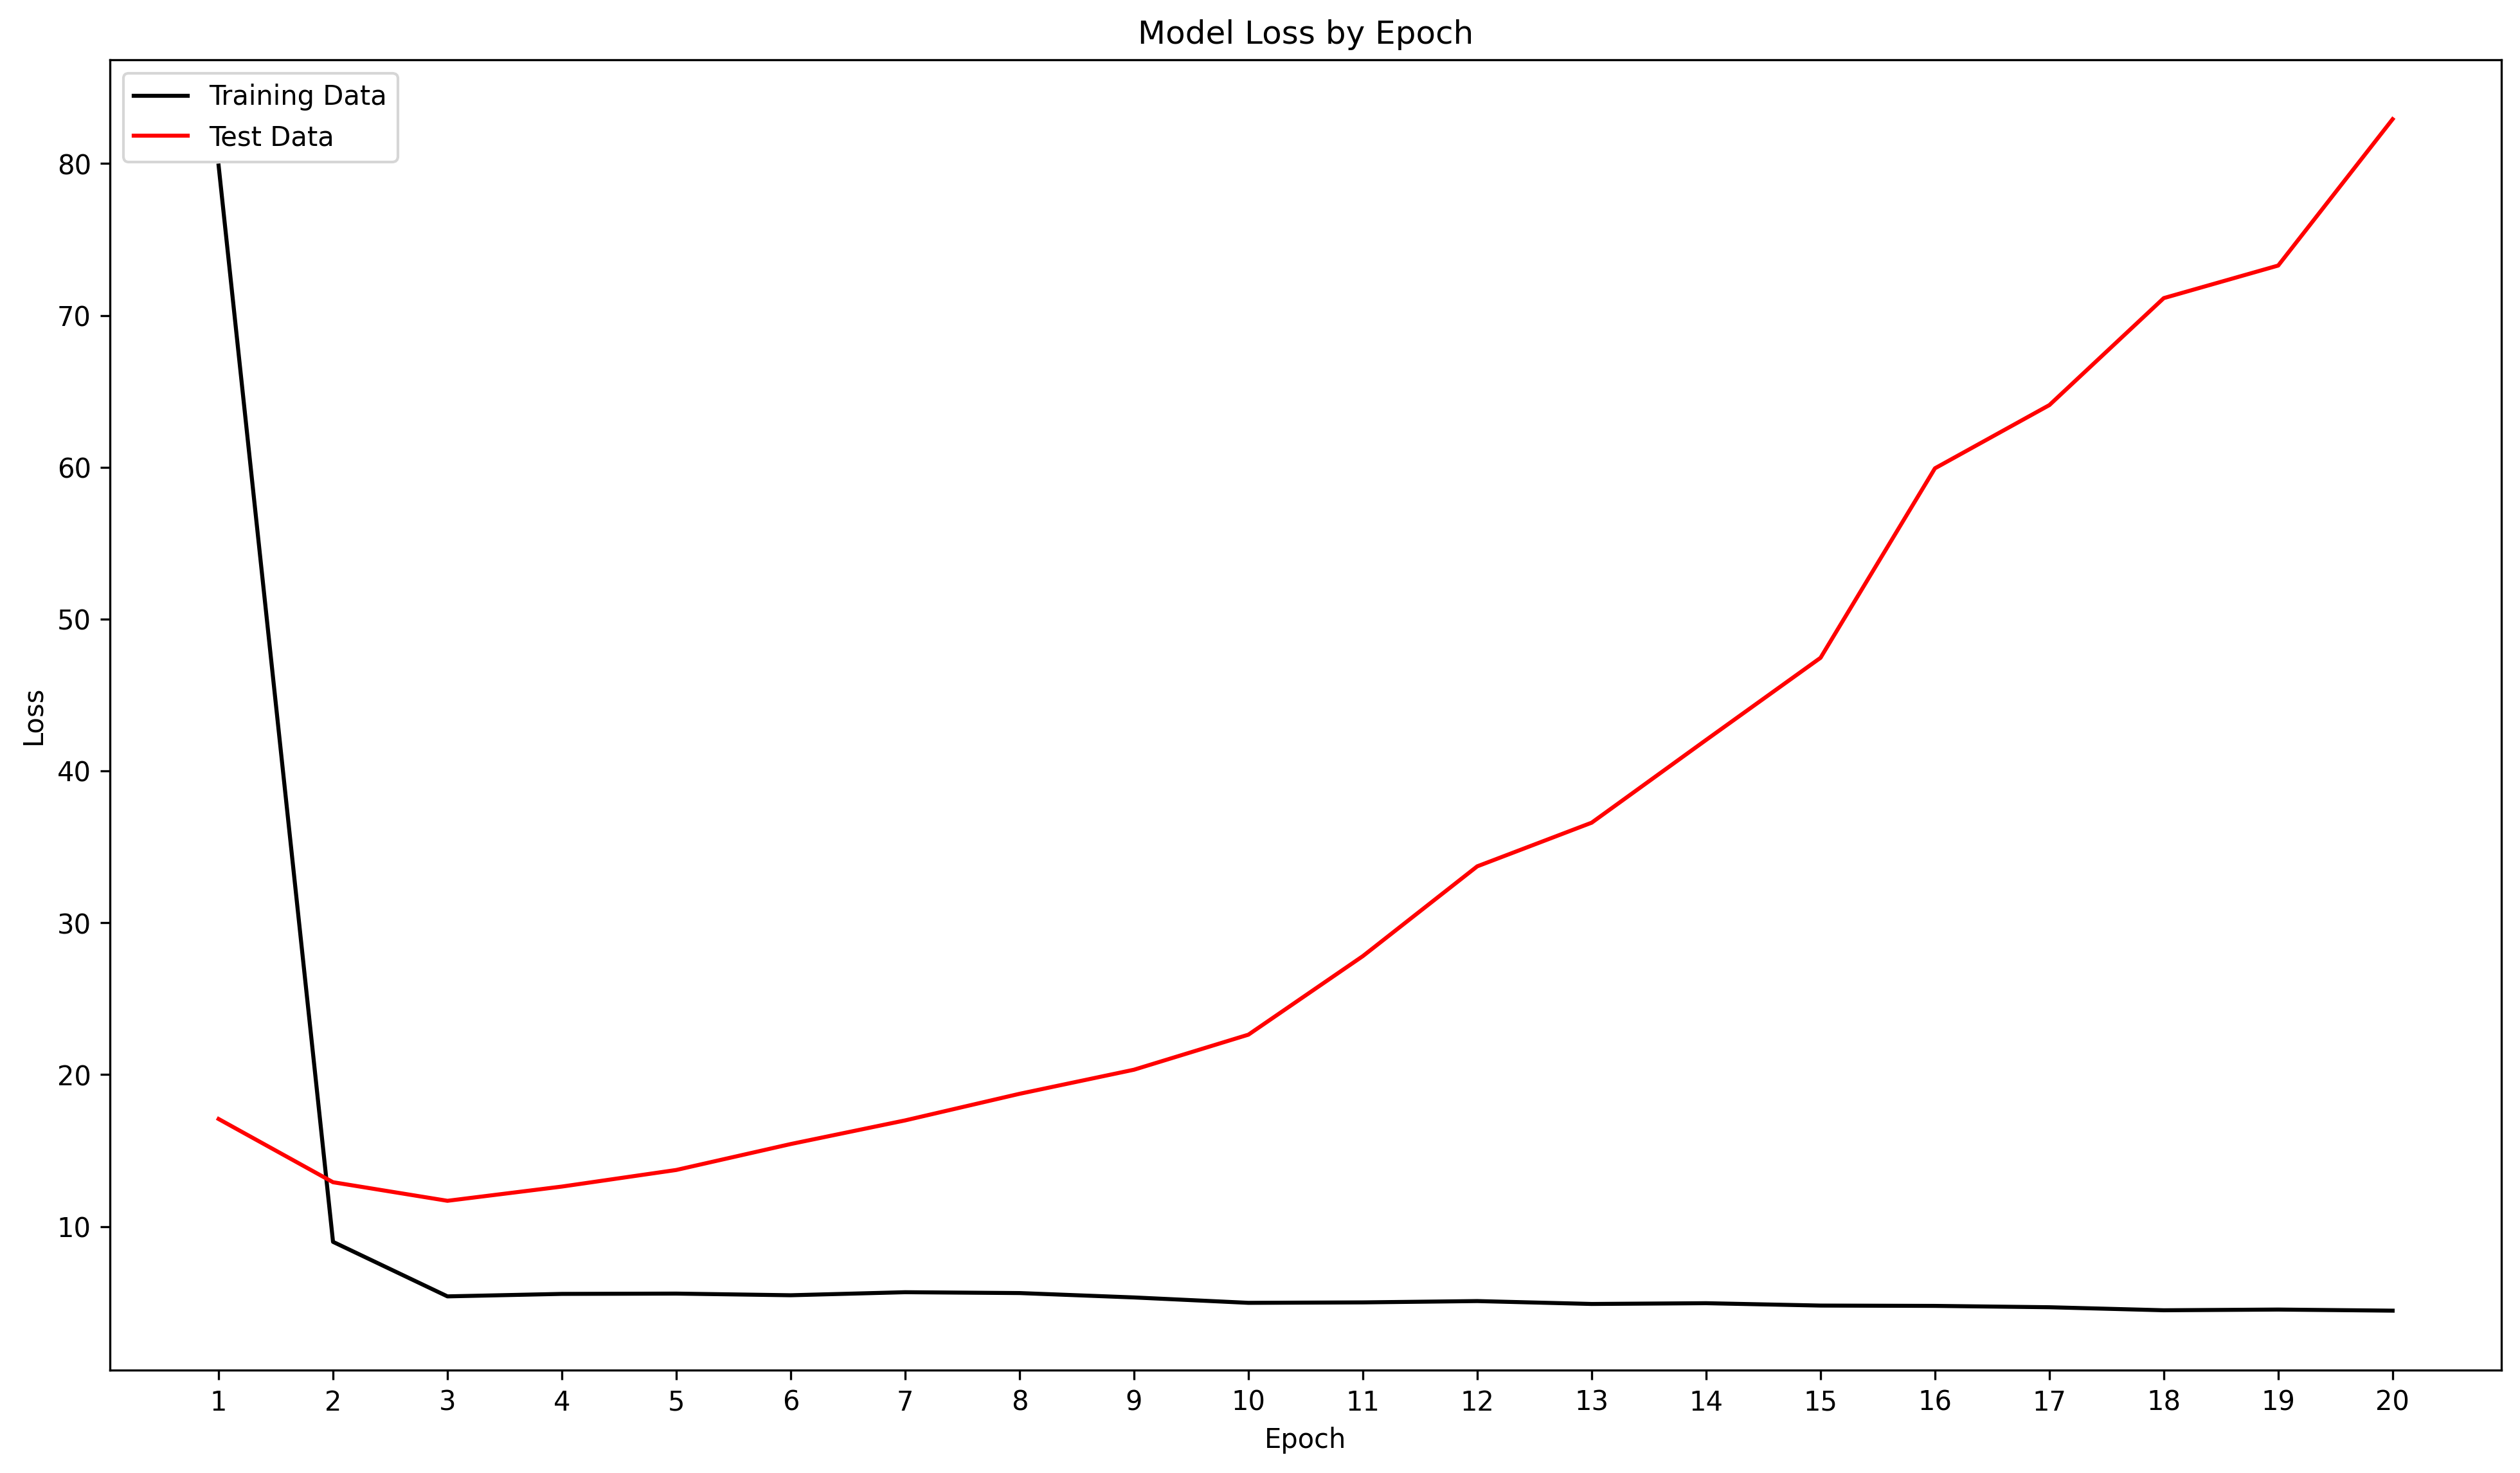

In [10]:
history = model.fit(X_train, Y_train, epochs=20, batch_size=4, verbose=1, validation_data=(X_val, Y_val))

# Plot a loss chart
fig, ax = plt.subplots(figsize=(16,9), dpi=300)
plt.title(label='Model Loss by Epoch', loc='center')

ax.plot(history.history['loss'], label='Training Data', color='black')
ax.plot(history.history['val_loss'], label='Test Data', color='red')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.xticks(ticks=np.arange(len(history.history['loss'])), labels=np.arange(1, len(history.history['loss'])+1))
plt.legend()

plt.show()

Epoch 1/20
25/25 [==============================] - 9s 375ms/step - loss: 94.3705 - val_loss: 19.5909
Epoch 2/20
25/25 [==============================] - 9s 366ms/step - loss: 13.0981 - val_loss: 16.3474
Epoch 3/20
25/25 [==============================] - 9s 366ms/step - loss: 5.7310 - val_loss: 15.1828
Epoch 4/20
25/25 [==============================] - 9s 366ms/step - loss: 5.6019 - val_loss: 13.8199
Epoch 5/20
25/25 [==============================] - 9s 366ms/step - loss: 5.7791 - val_loss: 14.1356
Epoch 6/20
25/25 [==============================] - 9s 366ms/step - loss: 5.9947 - val_loss: 15.1515
Epoch 7/20
25/25 [==============================] - 9s 366ms/step - loss: 5.6349 - val_loss: 16.3967
Epoch 8/20
25/25 [==============================] - 9s 366ms/step - loss: 5.6190 - val_loss: 17.6784
Epoch 9/20
25/25 [==============================] - 9s 366ms/step - loss: 5.3596 - val_loss: 18.8320
Epoch 10/20
25/25 [==============================] - 9s 365ms/step - loss: 5.4533 - val_l

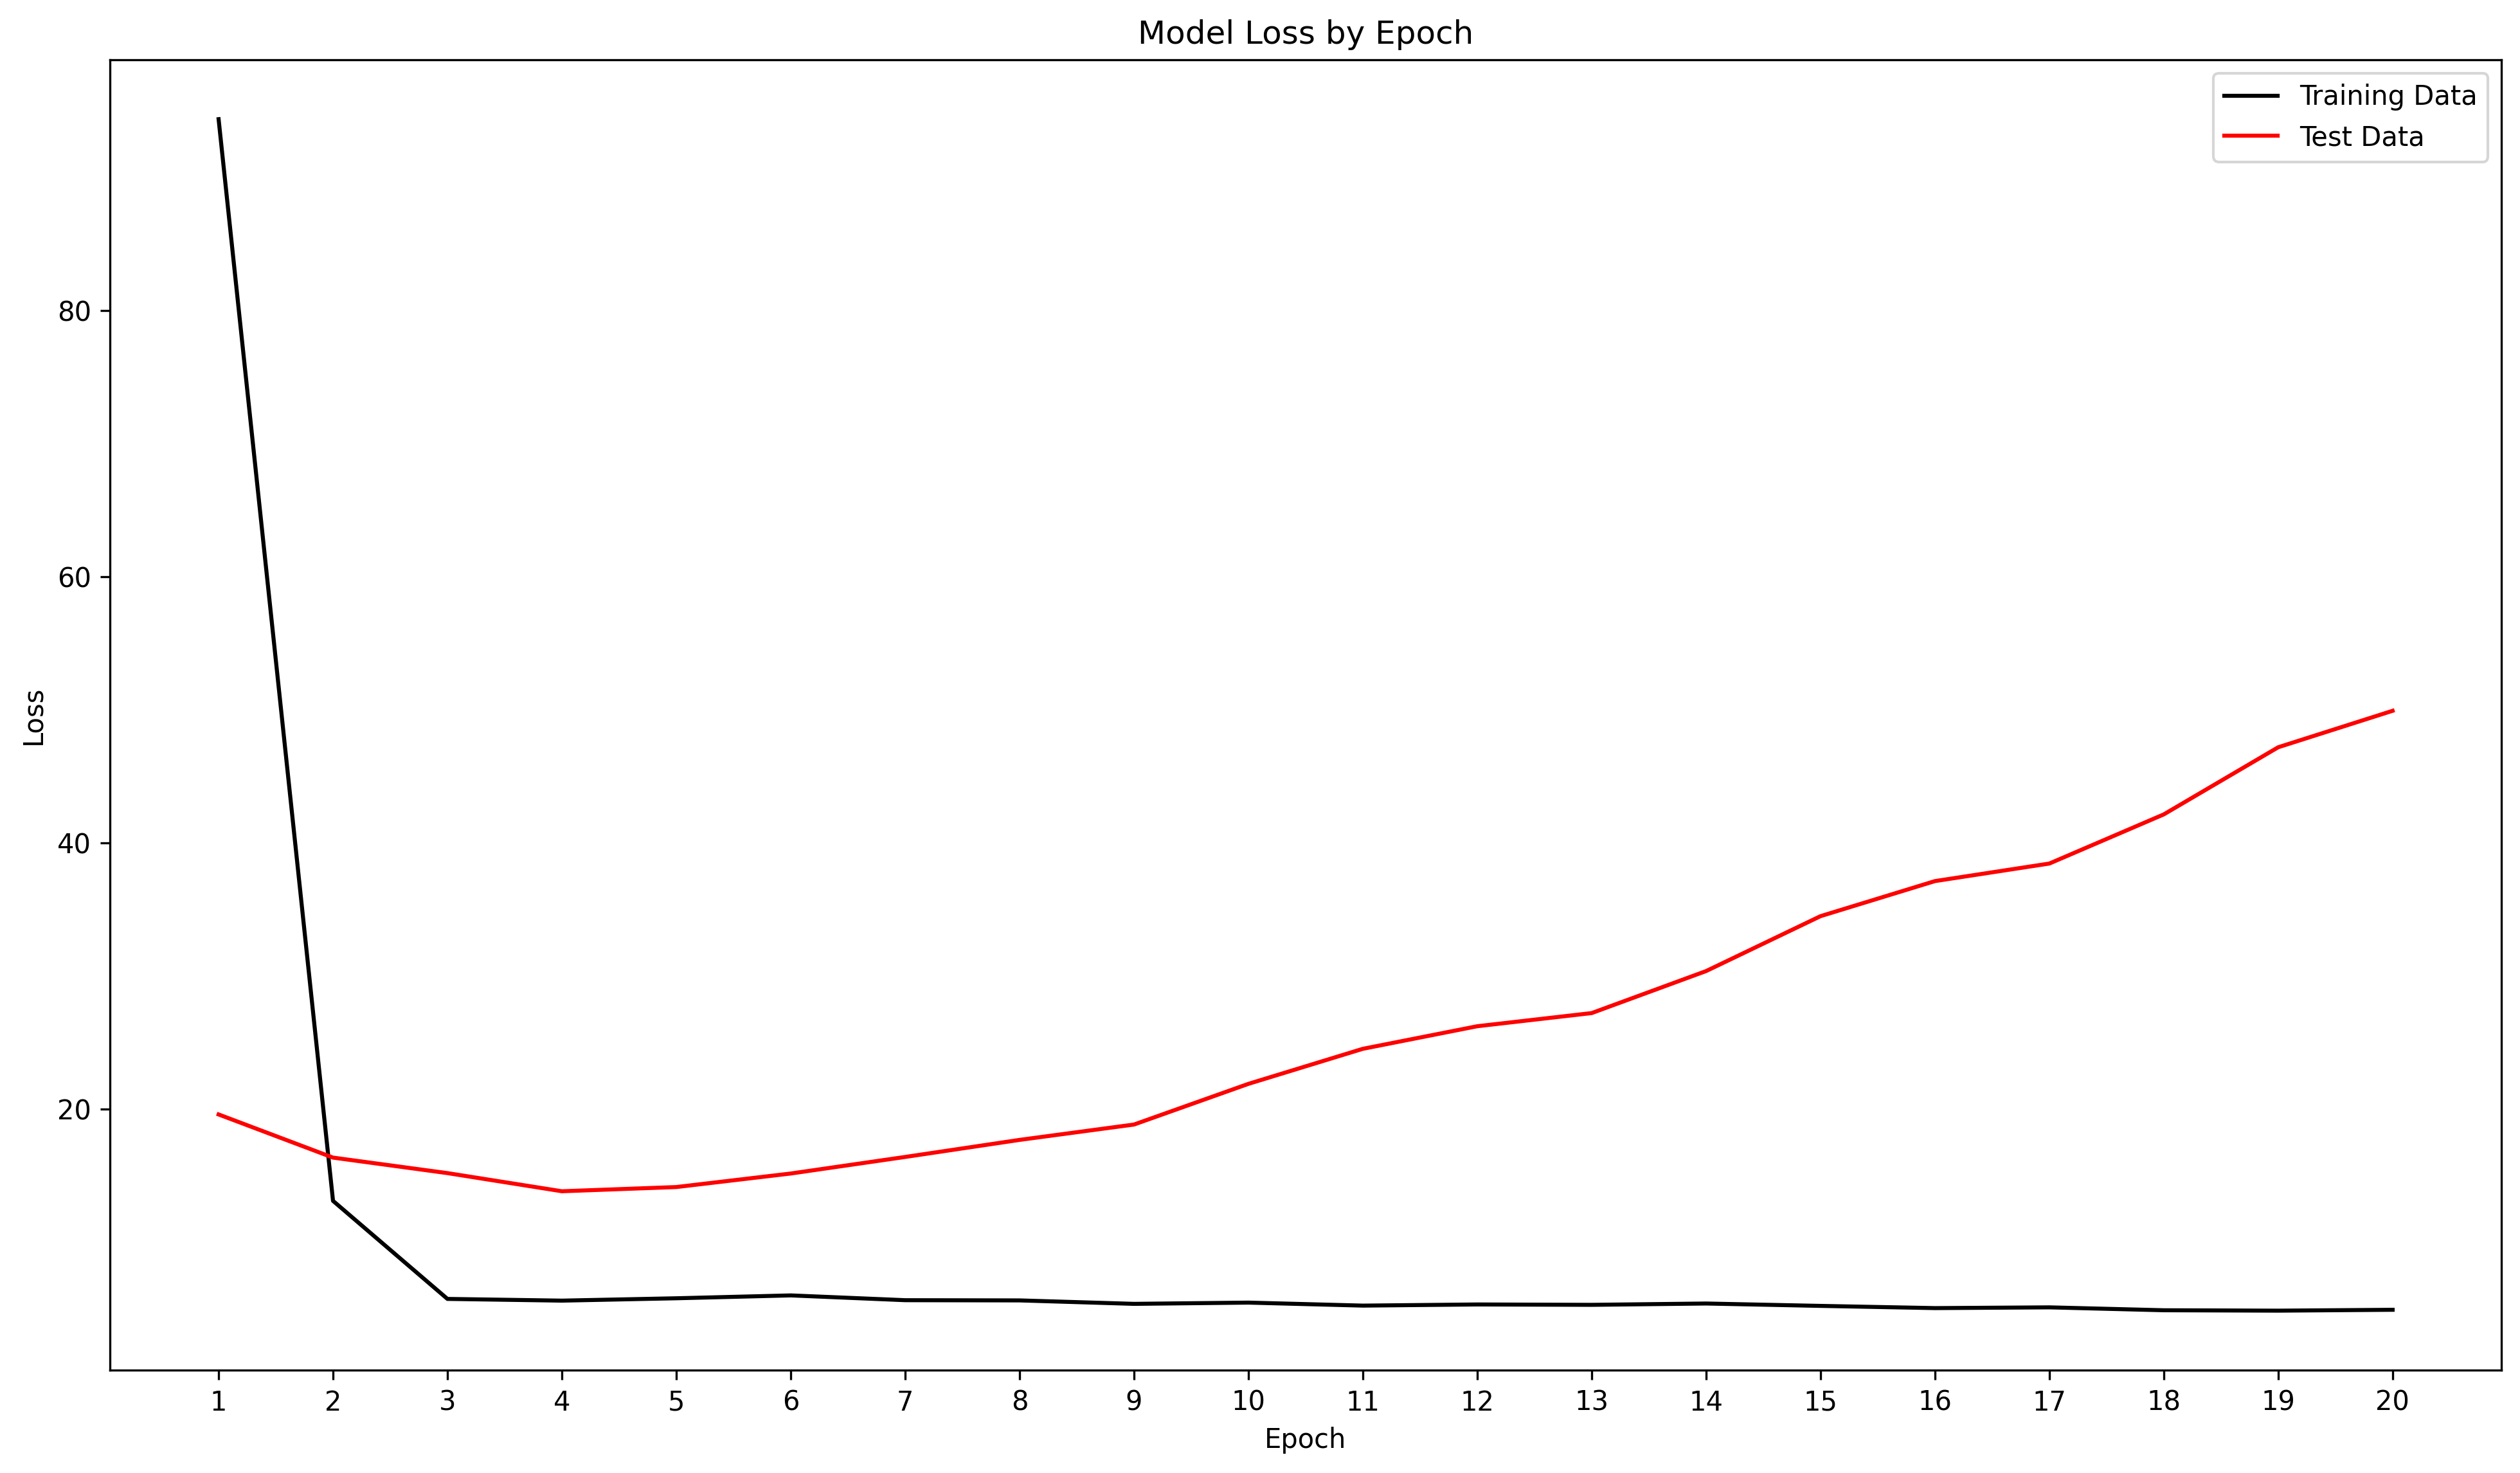

In [14]:
history = model.fit(X_train, Y_train, epochs=20, batch_size=5, verbose=1, validation_data=(X_val, Y_val))

# Plot a loss chart
fig, ax = plt.subplots(figsize=(16,9), dpi=300)
plt.title(label='Model Loss by Epoch', loc='center')

ax.plot(history.history['loss'], label='Training Data', color='black')
ax.plot(history.history['val_loss'], label='Test Data', color='red')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.xticks(ticks=np.arange(len(history.history['loss'])), labels=np.arange(1, len(history.history['loss'])+1))
plt.legend()

plt.show()

Epoch 1/50


2023-07-02 16:39:45.242377: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


25/25 [==============================] - 11s 378ms/step - loss: 84.8126 - val_loss: 19.7042
Epoch 2/50
25/25 [==============================] - 9s 365ms/step - loss: 11.9180 - val_loss: 15.7964
Epoch 3/50
25/25 [==============================] - 9s 366ms/step - loss: 5.6183 - val_loss: 14.2958
Epoch 4/50
25/25 [==============================] - 9s 366ms/step - loss: 5.5388 - val_loss: 13.2814
Epoch 5/50
25/25 [==============================] - 9s 366ms/step - loss: 5.2830 - val_loss: 14.0681
Epoch 6/50
25/25 [==============================] - 9s 366ms/step - loss: 5.5202 - val_loss: 15.0403
Epoch 7/50
25/25 [==============================] - 9s 366ms/step - loss: 5.4223 - val_loss: 15.6734
Epoch 8/50
25/25 [==============================] - 9s 366ms/step - loss: 5.4450 - val_loss: 15.4941
Epoch 9/50
25/25 [==============================] - 9s 366ms/step - loss: 5.3647 - val_loss: 17.5595
Epoch 10/50
25/25 [==============================] - 9s 366ms/step - loss: 5.2680 - val_loss: 18.73

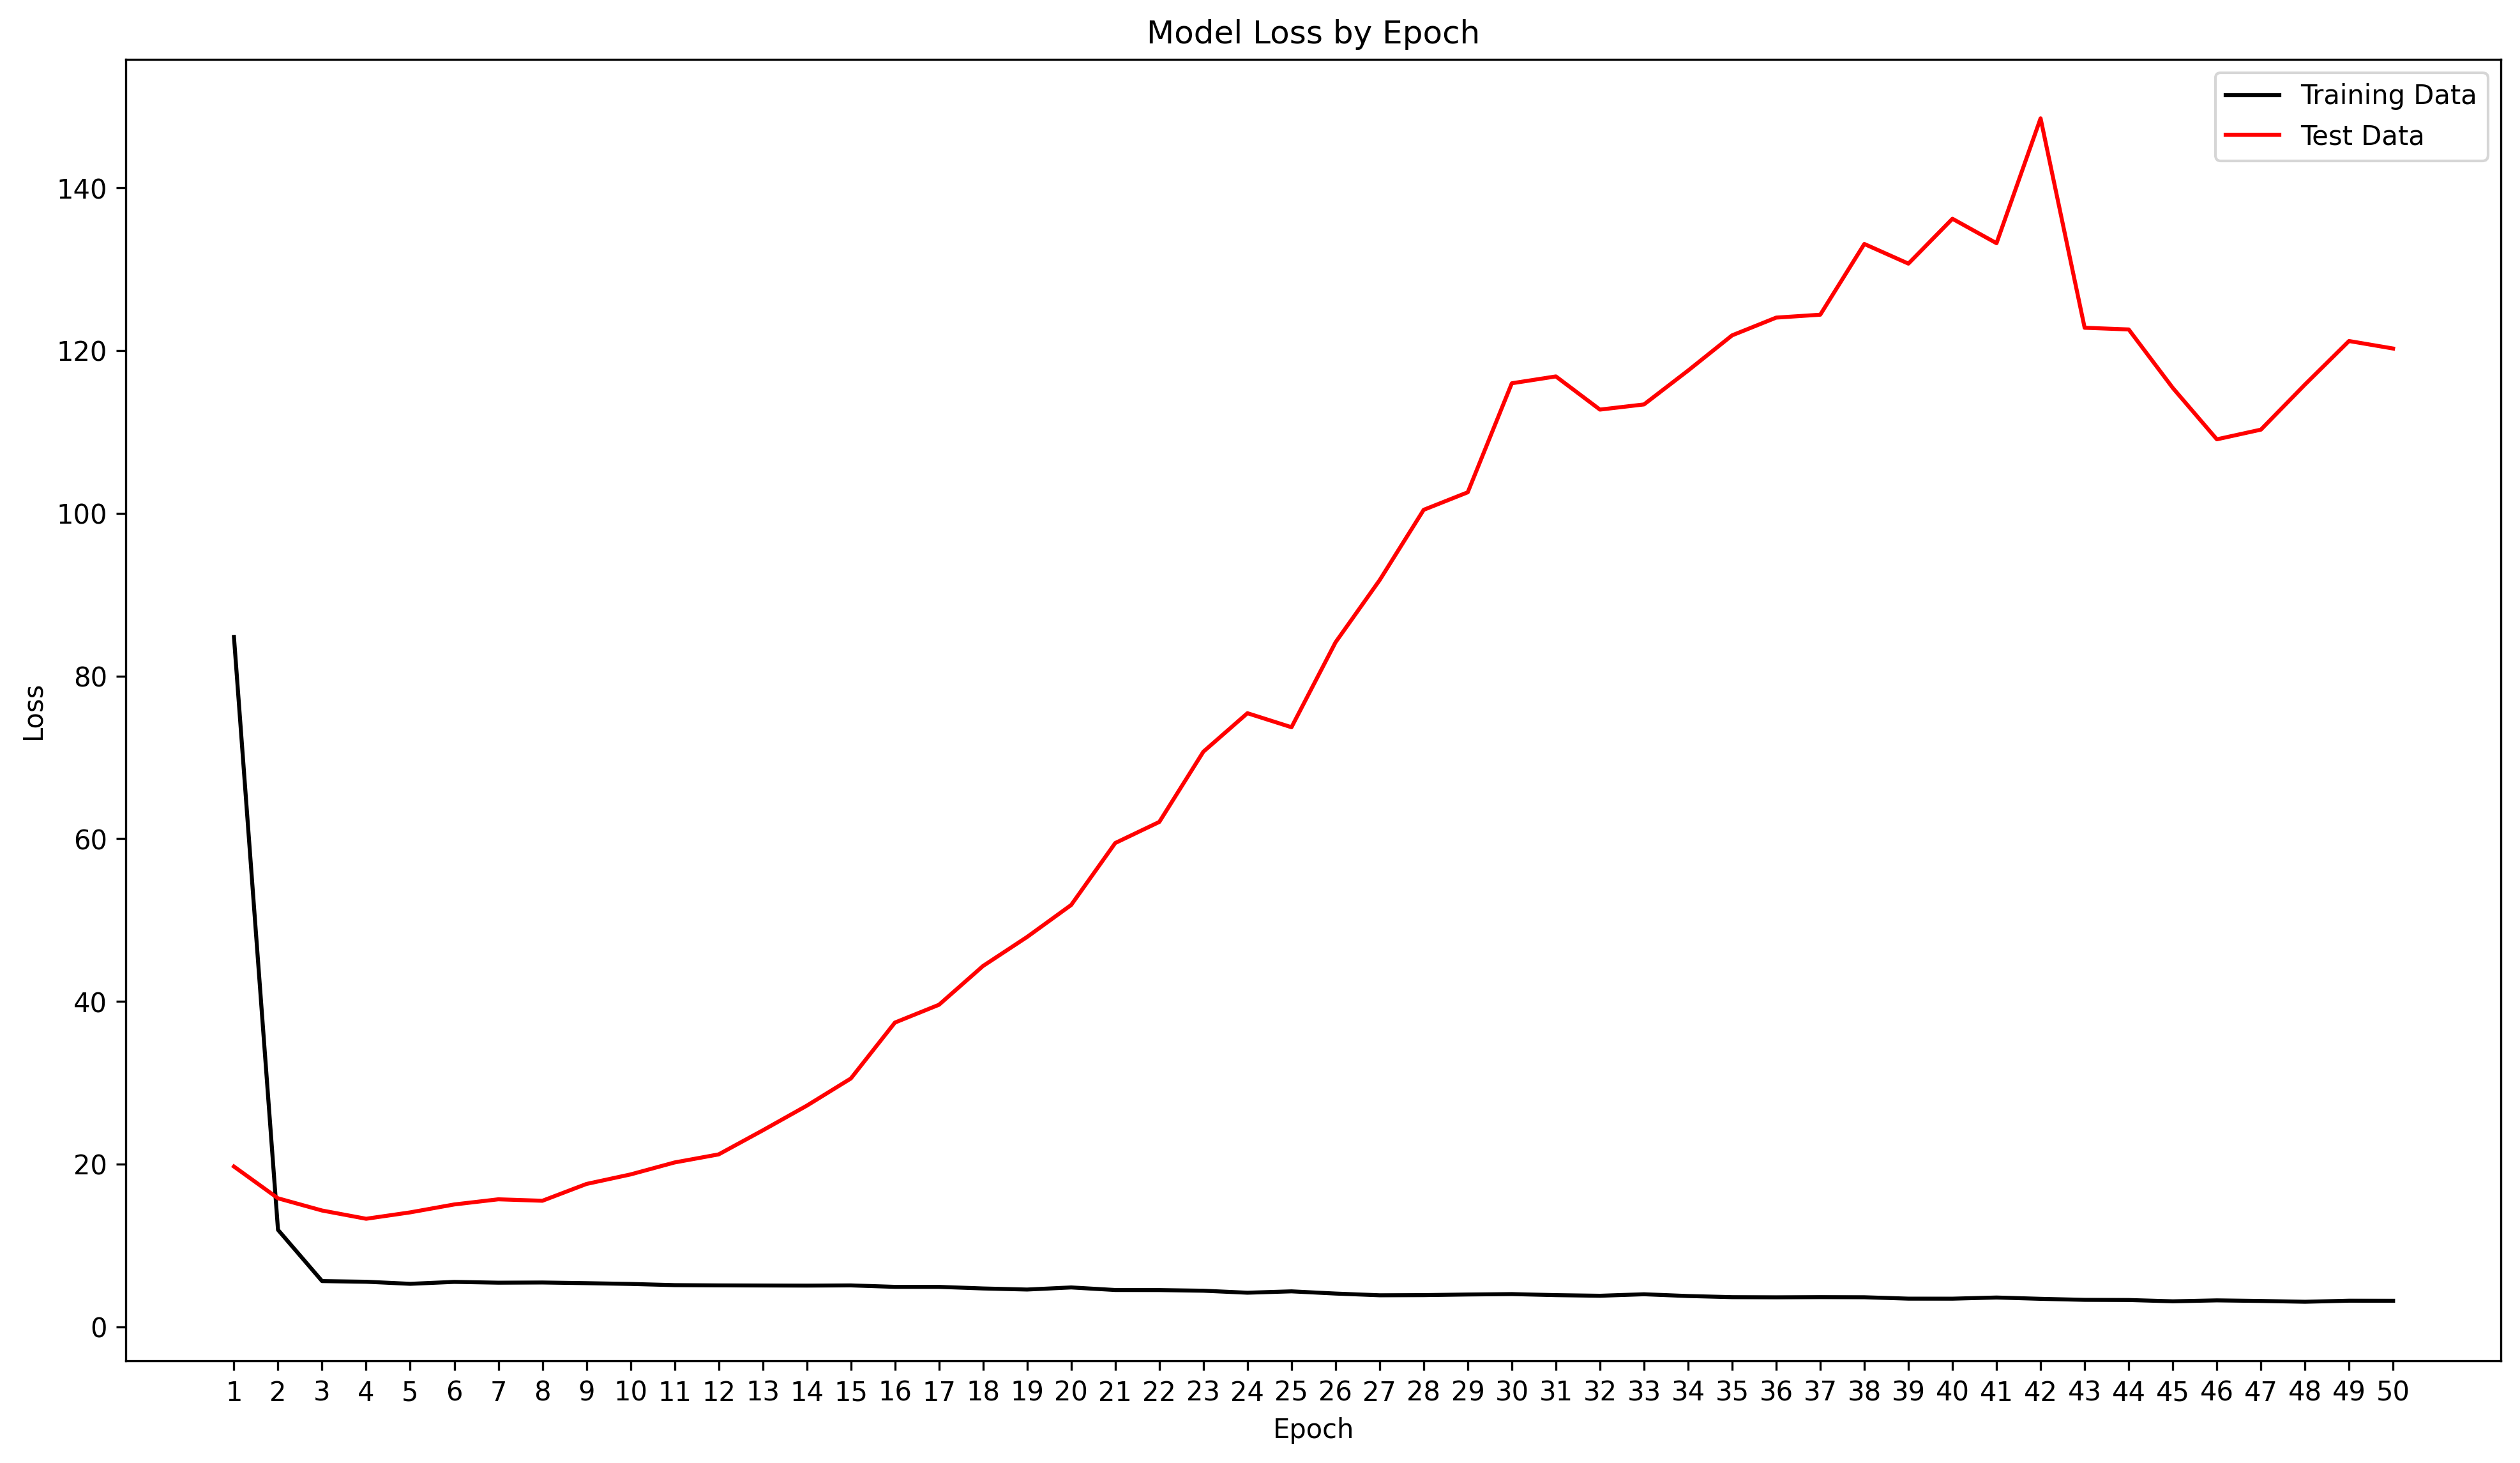

In [11]:
history = model.fit(X_train, Y_train, epochs=50, batch_size=5, verbose=1, validation_data=(X_val, Y_val))

# Plot a loss chart
fig, ax = plt.subplots(figsize=(16,9), dpi=300)
plt.title(label='Model Loss by Epoch', loc='center')

ax.plot(history.history['loss'], label='Training Data', color='black')
ax.plot(history.history['val_loss'], label='Test Data', color='red')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.xticks(ticks=np.arange(len(history.history['loss'])), labels=np.arange(1, len(history.history['loss'])+1))
plt.legend()

plt.show()

In [16]:
model.save('/home/pl/Documents/practice_data/')

INFO:tensorflow:Assets written to: /home/pl/Documents/practice_data/assets


INFO:tensorflow:Assets written to: /home/pl/Documents/practice_data/assets
